# Pleasant Lake Example

* **[View the configuration file(s)](https://aleaf.github.io/modflow-setup/latest/config-file-gallery.html#pleasant-lake-test-case)** 
* **[Run this example](https://mybinder.org/v2/gh/aleaf/modflow-setup/develop?urlpath=lab/tree/examples)  on  [Binder](https://mybinder.org/)**

#### Model details
* MODFLOW-6 model with local grid refinement (LGR)
* LGR parent model is itself a Telescopic Mesh Refinment (TMR) inset from a MODFLOW-NWT model
* Layer 1 in TMR parent model is subdivided evenly into two layers in LGR model (``botm: from_parent: 0: -0.5``). Other layers mapped explicitly between TMR parent and LGR model.
* starting heads from LGR parent model resampled from binary output from the TMR parent
* rch, npf, sto, and wel input copied from parent model
* SFR package constructed from an NHDPlus v2 dataset (path to NHDPlus files in the same structure as the `downloads from the NHDPlus website`_)
* head observations from csv files with different column names
* LGR inset extent based on a buffer distance around a feature of interest
* LGR inset dis, ic, npf, sto and rch packages copied from LGR parent
* WEL package created from custom format
* Lake package created from polygon features, bathymetry raster, stage-area-volume file and climate data from `PRISM`_.
* Lake package observations set up automatically (output file for each lake)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from mfsetup import MF6model
from mfsetup.discretization import cellids_to_kij
from gisutils import df2shp
import mfexport

wd = os.getcwd()

### Just make a model grid
Oftentimes at the start of a modeling project, we want to quickly test different grid resolutions and extents before attempting to build the model. We can do this with Modflow-setup by creating a model instance and then running the ``setup_grid()`` method. A model grid instance is created from the ``setup_grid:`` block in the configuration file. 

Note: ``%%capture`` in the block below is just to suppress printing of ``stdout`` for display of this notebook in the modflow-setup documentation.

In [2]:
%%capture
m = MF6model(cfg='pleasant_lgr_parent.yml')
m.setup_grid()

Since this model has local-grid refinement, it actually consists of two models: a parent built from ``pleasant_lgr_parent.yml``, and an inset built from ``pleasant_lgr_inset.yml``, which is referenced within ``pleasant_lgr_parent.yml``. The two sub-models are connected and solved simulataneously within the same MODFLOW 6 simulation. A model grid is made for each sub-model.

In [3]:
m.modelgrid

5 layer(s), 25 row(s), 25 column(s)
delr: [200.00...200.00] meters
delc: [200.00...200.00] meters
CRS: EPSG:3070
length units: meters
xll: 553000.0; yll: 388000.0; rotation: 0.0
Bounds: (553000.0, 558000.0, 388000.0, 393000.0)

In [4]:
m.inset['plsnt_lgr_inset'].modelgrid

70 row(s), 80 column(s)
delr: [40.00...40.00] meters
delc: [40.00...40.00] meters
CRS: EPSG:3070
length units: meters
xll: 554200.0; yll: 389000.0; rotation: 0.0
Bounds: (554200.0, 557400.0, 389000.0, 391800.0)

#### Working directory gottcha
Currently, to facilitate working with external files in Flopy, Modflow-setup changes the working directory to the model workspace. In the context of a flat script that only builds the model, this is fine, but in a notebook or other workflows, this can potentially cause confusion.

In [5]:
os.getcwd()

'/Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr'

### Write shapefiles of the inset and parent modelgrids
A shapefile of the grid bounding box is written by default on creation of the model grid, to the location specified by ``output_files: grid_file:`` in the ``setup_grid:`` block (default is ``<model workspace>/postproc/shps/``)

In [6]:
m.modelgrid.write_shapefile('postproc/shps/plsnt_lgr_parent_grid.shp')
m.inset['plsnt_lgr_inset'].modelgrid.write_shapefile('postproc/shps/plsnt_lgr_inset_grid.shp')

creating shapely Polygons of grid cells...
finished in 0.15s

writing postproc/shps/plsnt_lgr_parent_grid.shp... Done
creating shapely Polygons of grid cells...
finished in 0.05s

writing postproc/shps/plsnt_lgr_inset_grid.shp... Done


##### Change the working directory back to the notebook location

In [7]:
os.chdir(wd)

### Build the whole model

In [8]:
m = MF6model.setup_from_yaml('pleasant_lgr_parent.yml')

loading configuration file pleasant_lgr_parent.yml...

Setting up plsnt_lgr_parent model from data in None

loading parent model /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/pleasant.nam...
finished in 0.24s


validating configuration...
DIS package
done with validation.

setting up model grid...
wrote /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/plsnt_lgr_parent_grid.json
writing /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/postproc/shps/plsnt_lgr_parent_bbox.shp... Done
finished in 0.23s

loading configuration file /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr_inset.yml...

Setting up DIS package...
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/dem40m.tif...
finished in 0.20s
wrote ./external/plsnt_lgr_parent_top.dat, took 0.00s
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/botm0.tif..

creating shapely Polygons of grid cells...
finished in 0.01s

No other CHD input specified
finished in 5.83s


Setting up SFR package...

loading NHDPlus v2 hydrography data...
for basins:
/Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps

reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/NHDSnapshot/Hydrography/NHDFlowline.shp...
filtering on bounding box -89.58864189423825, 43.964148922793996, -89.52595875596734, 44.00940678140979...
--> building dataframe... (may take a while for large shapefiles)

reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/NHDPlusAttributes/PlusFlowlineVAA.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/NHDPlusAttributes/PlusFlow.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading /Users/aleaf/Doc

finished in 0.81s
wrote ./external/plsnt_lgr_inset_top.dat, took 0.02s
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/botm0.tif...
finished in 0.32s
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/botm1.tif...
finished in 0.08s
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/botm2.tif...
finished in 0.08s
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/botm3.tif...
finished in 0.08s
reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/pleasant_bathymetry.tif...
finished in 0.30s

reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/all_lakes.shp...
filtering on bounding box 554200.0, 389000.0, 557400.0, 391800.0...
--> building dataframe... (may take a while for large sha

finished in 0.29s

SFRmaker version 0.7.0.post15+gebe9af1

Creating sfr dataset...

Creating grid class instance from flopy Grid instance...
grid class created in 0.17s

Model grid information
structured grid
nnodes: 5,600
nlay: 1
nrow: 70
ncol: 80
model length units: undefined
crs: EPSG:3070
bounds: 554200.00, 389000.00, 557400.00, 391800.00
active area defined by: isfr array

/Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr
plsnt_lgr_inset model version 0.post240.dev0+g83a209a
Parent model: ./plsnt_lgr_parent
5 layer(s), 70 row(s), 80 column(s)
delr: [40.00...40.00] meters
delc: [40.00...40.00] meters
CRS: EPSG:3070
length units: meters
xll: 554200.0; yll: 389000.0; rotation: 0.0
Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
Packages: dis ic npf sto rcha oc
13 period(s):
 per start_datetime end_datetime  perlen  steady  nstp
   0     2012-01-01   2012-01-01     1.0    True     1
   1     2012-01-01   2012-02-01    31.0   False     1
   2     2012-02-01   2012-03-0

finished setting up model in 42.42s

Pleasant Lake test case version 0.1.post240.dev0+g83a209a
Parent model: /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/pleasant
5 layer(s), 25 row(s), 25 column(s)
delr: [200.00...200.00] meters
delc: [200.00...200.00] meters
CRS: EPSG:3070
length units: meters
xll: 553000.0; yll: 388000.0; rotation: 0.0
Bounds: (553000.0, 558000.0, 388000.0, 393000.0)
Packages: dis ic npf sto rcha oc chd_0 obs_0 sfr_0 wel_0 obs_1
13 period(s):
 per start_datetime end_datetime  perlen  steady  nstp
   0     2012-01-01   2012-01-01     1.0    True     1
   1     2012-01-01   2012-02-01    31.0   False     1
   2     2012-02-01   2012-03-01    29.0   False     1
   ...
  12     2012-12-01   2013-01-01    31.0   False     1


a ``MF6model`` instance (subclass of ``flopy.mf6.ModflowGwf``) is returned

In [9]:
m

Pleasant Lake test case version 0.1.post240.dev0+g83a209a
Parent model: /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/pleasant
5 layer(s), 25 row(s), 25 column(s)
delr: [200.00...200.00] meters
delc: [200.00...200.00] meters
CRS: EPSG:3070
length units: meters
xll: 553000.0; yll: 388000.0; rotation: 0.0
Bounds: (553000.0, 558000.0, 388000.0, 393000.0)
Packages: dis ic npf sto rcha oc chd_0 obs_0 sfr_0 wel_0 obs_1
13 period(s):
 per start_datetime end_datetime  perlen  steady  nstp
   0     2012-01-01   2012-01-01     1.0    True     1
   1     2012-01-01   2012-02-01    31.0   False     1
   2     2012-02-01   2012-03-01    29.0   False     1
   ...
  12     2012-12-01   2013-01-01    31.0   False     1

information from the configuration file is stored in an attached ``cfg`` dictionary

In [10]:
m.cfg.keys()

dict_keys(['metadata', 'simulation', 'model', 'parent', 'intermediate_data', 'postprocessing', 'setup_grid', 'dis', 'tdis', 'ic', 'npf', 'sto', 'rch', 'sfr', 'high_k_lakes', 'lak', 'mvr', 'riv', 'wel', 'chd', 'oc', 'obs', 'ims', 'filename', 'ghb', 'maw', 'external_files', 'grid'])

the ``cfg`` dictionary contains both information from the configuration file, and MODFLOW input (such as external text file arrays) that was developed from the original source data. Internally in Modflow-setup, MODFLOW input in ``cfg`` is fed to the various Flopy object constructors.

In [11]:
m.cfg['dis']

defaultdict(dict,
            {'remake_top': True,
             'options': {'length_units': 'meters'},
             'dimensions': {'nlay': 5},
             'griddata': {'top': [{'filename': './external/plsnt_lgr_parent_top.dat'}],
              'botm': [{'filename': './external/plsnt_lgr_parent_botm_000.dat'},
               {'filename': './external/plsnt_lgr_parent_botm_001.dat'},
               {'filename': './external/plsnt_lgr_parent_botm_002.dat'},
               {'filename': './external/plsnt_lgr_parent_botm_003.dat'},
               {'filename': './external/plsnt_lgr_parent_botm_004.dat'}],
              'idomain': [{'filename': './external/plsnt_lgr_parent_idomain_000.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain_001.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain_002.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain_003.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain_004.dat'}]},
  

The inset LGR model is attached to the parent within an ``inset`` dictionary

In [12]:
m.inset

{'plsnt_lgr_inset': plsnt_lgr_inset model version 0.post240.dev0+g83a209a
 Parent model: ./plsnt_lgr_parent
 5 layer(s), 70 row(s), 80 column(s)
 delr: [40.00...40.00] meters
 delc: [40.00...40.00] meters
 CRS: EPSG:3070
 length units: meters
 xll: 554200.0; yll: 389000.0; rotation: 0.0
 Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
 Packages: dis ic npf sto rcha oc sfr_0 lak_0 obs_0 wel_0 obs_1
 13 period(s):
  per start_datetime end_datetime  perlen  steady  nstp
    0     2012-01-01   2012-01-01     1.0    True     1
    1     2012-01-01   2012-02-01    31.0   False     1
    2     2012-02-01   2012-03-01    29.0   False     1
    ...
   12     2012-12-01   2013-01-01    31.0   False     1}

#### Plot the inset and parent model grids with Lake Package connections by layer

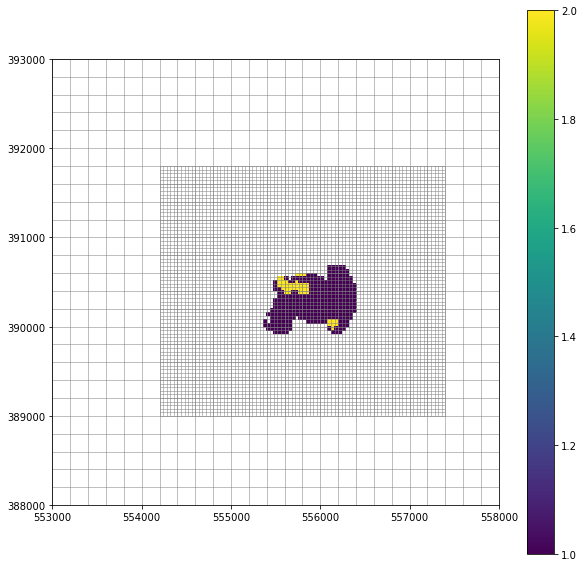

In [13]:
inset = m.inset['plsnt_lgr_inset']

l, r, b, t = m.modelgrid.extent
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

vconn = inset.lak.connectiondata.array[inset.lak.connectiondata.array['claktype'] == 'vertical']
k, i, j = cellids_to_kij(vconn['cellid'])
lakeconnections = np.zeros((inset.nrow, inset.ncol))
lakeconnections[i, j] = np.array(k)
lakeconnections = np.ma.masked_array(lakeconnections, mask=lakeconnections == 0)
qmi = inset_mv.plot_array(lakeconnections)

#inset_mv.plot_bc('LAK', color='navy')
#parent_mv.plot_bc('WEL_0', color='red')

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
plt.colorbar(qmi)

### write the MODFLOW input files
(just like you would for a Flopy model)

In [14]:
m.write_input()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing mvr package pleasant_lgr.mvr...
  writing package pleasant_lgr.gwfgwf...
  writing model plsnt_lgr_parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writing package oc...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 240 based on size of stress_period_data
    writing package obs_0...
    writing package sfr_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package obs_1...
  writing model plsnt_lgr_inset...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writ

### Run the model

In [15]:
m.simulation.run_simulation()

FloPy is using the following  executable to run the model: /Users/aleaf/Documents/software/modflow_exes/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 29 2020 12:19:52 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer t

(True, [])

### Plot the head results

In [16]:
tmr_parent_headsobj = bf.HeadFile('../data/pleasant/pleasant.hds')
lgr_parent_headsobj = bf.HeadFile('plsnt_lgr_parent.hds')
lgr_inset_headsobj = bf.HeadFile('plsnt_lgr_inset.hds')

tmr_parent_hds = tmr_parent_headsobj.get_data(kstpkper=(4, 12))
lgr_parent_hds = lgr_parent_headsobj.get_data(kstpkper=(0, 12))
lgr_inset_hds = lgr_inset_headsobj.get_data(kstpkper=(0, 12))

lgr_parent_hds = np.ma.masked_array(lgr_parent_hds, mask=lgr_parent_hds == 1e30)
lgr_inset_hds = np.ma.masked_array(lgr_inset_hds, mask=lgr_inset_hds == 1e30)

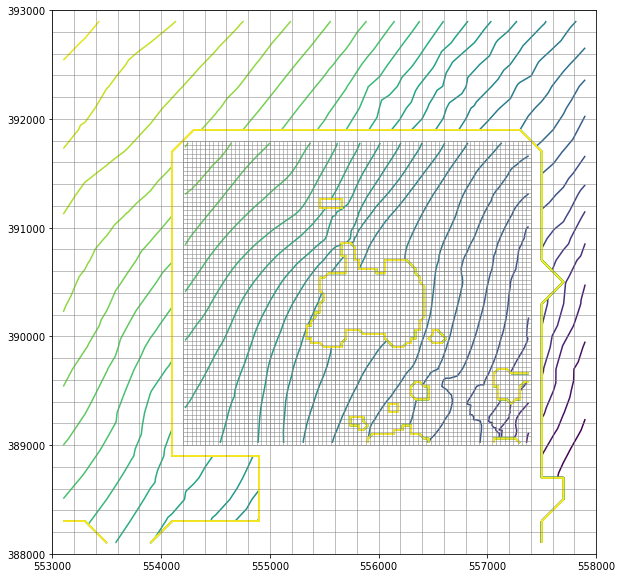

In [17]:
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

pctr = parent_mv.contour_array(lgr_parent_hds, levels=np.arange(290, 315))
ictr = inset_mv.contour_array(lgr_inset_hds, levels=np.arange(290, 315))
#qmp = parent_mv.plot_array(lgr_parent_hds)
#qmi = inset_mv.plot_array(lgr_inset_hds)

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
#plt.colorbar(qmp)

### Use [Modflow-export](https://github.com/aleaf/modflow-export) to export the modflow input to PDFs, rasters and shapefiles

In [18]:
for model in m, inset:
    mfexport.export(model, model.modelgrid, output_path=f'postproc/{model.name}/')

creating postproc/plsnt_lgr_parent/pdfs...
creating postproc/plsnt_lgr_parent/shps...
creating postproc/plsnt_lgr_parent/rasters...

dis package...
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay4.tif
top:
wrote postproc/plsnt_lgr_parent/rasters/top.tif
botm:
wrote postproc/plsnt_lgr_parent/rasters/botm_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay4.tif
idomain:
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_

wrote postproc/plsnt_lgr_inset/rasters/recharge_per10.tif
wrote postproc/plsnt_lgr_inset/rasters/recharge_per11.tif
wrote postproc/plsnt_lgr_inset/rasters/recharge_per12.tif

sfr_0 package...

lak_0 package...
skipped, not implemented yet

obs_0 package...
skipped, not implemented yet

wel_0 package...
writing postproc/plsnt_lgr_inset/shps/wel0_stress_period_data.shp... Done
q:
boundname:
Warning, variable: boundname
Export of non-period data from transientlists not implemented!

obs_1 package...
writing postproc/plsnt_lgr_inset/shps/obs1_stress_period_data.shp... Done


#### Modflow-export can also create a summary table of the model inputs

In [19]:
for model in m, inset:
    mfexport.summarize(model, output_path=f'postproc/{model.name}/')

summarizing plsnt_lgr_parent input...
summarizing plsnt_lgr_inset input...
skipped, not implemented yet
